# iX-Artikel "Beziehungssache"

von Stefanie Scholz und Christian Winkler

## Voraussetzungen

Achtung, das Notebook ist alleine nicht direkt ablauffähig. Wir dürfen die Reddit-Daten leider nicht mitliefern.

Daher sind folgende Schritte notwendig:
* Script `00-01-download.py` aufrufen (am besten auf dem eigenen Computer, in Google Colab evtl. auch möglich, aber es läuft sehr lang)
  * Das Script lädt die List der URLs herunter, falls sie noch nicht existiert
  * Für jede URL wird das entsprechende JSON-File heruntergeladen, wenn es noch nicht existiert
  * Auf diese Weise kann das Skript neu gestartet werden, wenn es abbricht
  * Abhängig von der Internet-Anbindung kann das Skript sehr, sehr lange laufen

* Script `00-02-insert.py` aufrufen
  * Zunächst wird eine SQLite-Datenbank angelegt
  * Anschließend werden alle Kommentare eingelesen
  * Die Kommentare werden analysiert
  * Die Kommentare werden in der Datenbank gespeichert
  * Schließlich wird ein View erzeugt
  * Das Skript läuft etwa zehn Minuten
  
Als Ergebnis steht dann eine SQLite-Datenbank zur Verfügung, in der alle Posts und Kommentare gespeichert sind. Diese dient als Basis für die Analyse. 

Da einige Kommentare gesperrt wurden, neue hinzugekommen sind usw. können sich leicht andere Ergebnisse als im Artikel ergeben.

## Imports und Vorbereitung

In [1]:
import pandas as pd
import sqlite3

In [2]:
sql = sqlite3.connect("reddit.db")

## Statistik über Posts

<AxesSubplot:title={'center':'Toplevel-Posts pro Quartal'}, xlabel='time'>

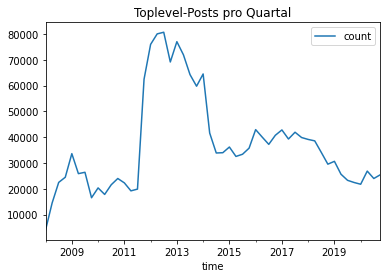

In [3]:
time_top = pd.read_sql("SELECT STRFTIME('%Y-%m-01', created_utc) AS time, COUNT(*) AS count \
FROM posts2020 WHERE parent_id IS NULL GROUP BY time", sql, parse_dates=["time"])
time_top.set_index("time").resample('Q').sum().plot(title="Toplevel-Posts pro Quartal")

<AxesSubplot:title={'center':'Gesamtposts pro Quartal'}, xlabel='time'>

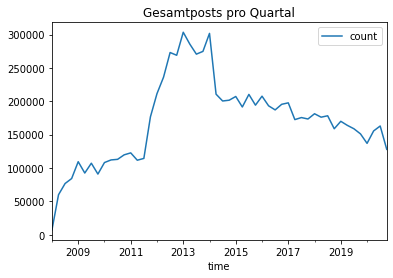

In [4]:
time_total = pd.read_sql("SELECT STRFTIME('%Y-%m-01', created_utc) AS time, COUNT(*) AS count \
FROM posts2020 GROUP BY time", sql, parse_dates=["time"])
time_total.set_index("time").resample('Q').sum().plot(title="Gesamtposts pro Quartal")

## Score vs. Anzahl Kommentare

In [5]:
sc_top10 = pd.read_sql("SELECT p.id, AVG(p.score) AS score, COUNT(*) AS count\
    FROM toplevel_posts2020 p, posts2020 c\
    WHERE c.parent_id=p.id GROUP BY p.id\
    HAVING count>10", sql)

<Figure size 1152x1152 with 0 Axes>

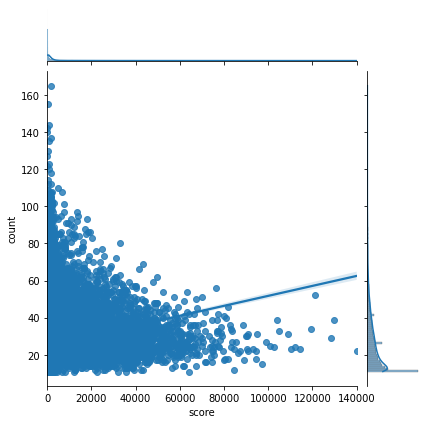

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))
sns.jointplot(x="score", y="count", data=sc_top10, kind="reg")

In [7]:
import scipy.stats
scipy.stats.linregress(sc_top10["score"], sc_top10["count"])

LinregressResult(slope=0.0002685501607911447, intercept=24.91059480916516, rvalue=0.15453029403296029, pvalue=1.8532920635102188e-237, stderr=8.112025699408762e-06, intercept_stderr=0.07248555635581365)

## Flairs

In [8]:
time_flair = pd.read_sql("SELECT STRFTIME ('%Y', created_utc) AS year, flair, COUNT(*) AS count \
    FROM posts2020 WHERE flair IS NOT NULL\
    GROUP BY year, flair HAVING count>500", sql)

In [9]:
time_flair.pivot(index="flair", columns="year", values="count").fillna(0)

year,2013,2014,2015,2016,2017,2018,2019,2020
flair,,,,,,,,
AI,0.0,0.0,654.0,1242.0,1804.0,2296.0,931.0,0.0
Artificial Intelligence,0.0,0.0,0.0,0.0,0.0,0.0,658.0,3048.0
Biotech,0.0,0.0,993.0,1000.0,1040.0,1112.0,0.0,0.0
Biotechnology,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1227.0
Business,0.0,9359.0,12980.0,9039.0,7305.0,7773.0,7199.0,10879.0
Comcast,0.0,700.0,832.0,0.0,0.0,0.0,0.0,0.0
Crypto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,832.0
Discussion,0.0,3095.0,4216.0,6197.0,7180.0,8876.0,6432.0,955.0
Energy,0.0,0.0,1239.0,1154.0,1698.0,1789.0,1025.0,1133.0


<AxesSubplot:xlabel='year', ylabel='flair'>

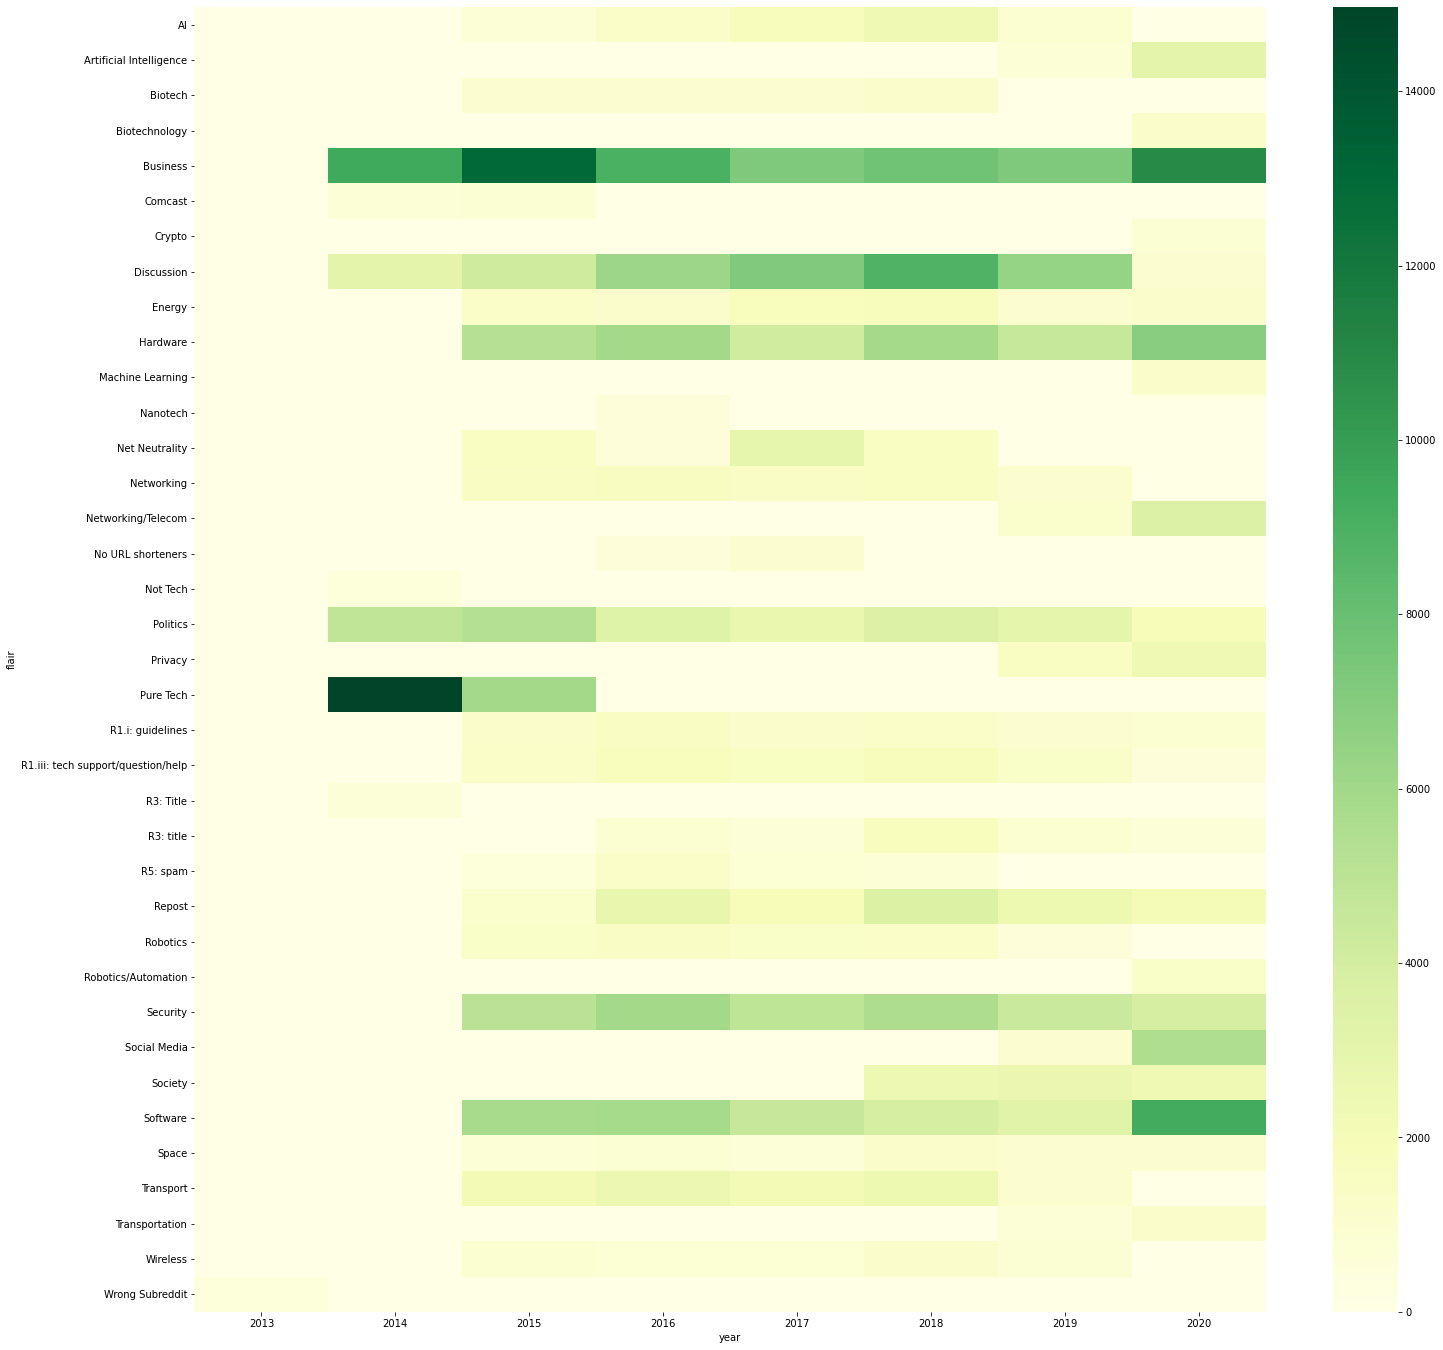

In [10]:
import seaborn as sns
plt.figure(figsize=(24,24))
sns.heatmap(time_flair.pivot(index="flair", columns="year", values="count").fillna(0), cmap="YlGn")

## Biotechnology und Biotech

In [11]:
bio_flair = pd.read_sql("SELECT STRFTIME('%Y-%m', created_utc) AS month, flair, COUNT(*) AS count \
                          FROM posts2020 WHERE flair IN ('Biotechnology', 'Biotech')\
                          GROUP BY month, flair", sql)

<AxesSubplot:xlabel='month'>

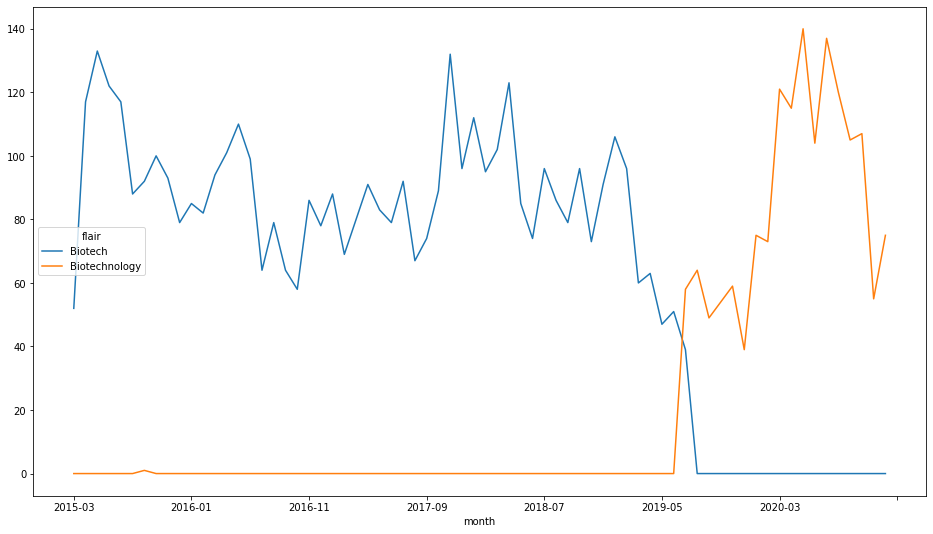

In [12]:
bio_fp = bio_flair.pivot(index="month", columns="flair", values="count").fillna(0)
bio_fp.plot(figsize=(16,9))

## Artificial Intelligence, AI und Vorhersage

In [13]:
# leider hat sich der Namen des Pakets geändert
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [14]:
ai_flair = pd.read_sql("SELECT STRFTIME('%Y-%m', created_utc) AS month, flair, COUNT(*) AS count \
                          FROM posts2020 WHERE flair IN ('Artificial Intelligence', 'AI')\
                          GROUP BY month, flair", sql)

<AxesSubplot:xlabel='month'>

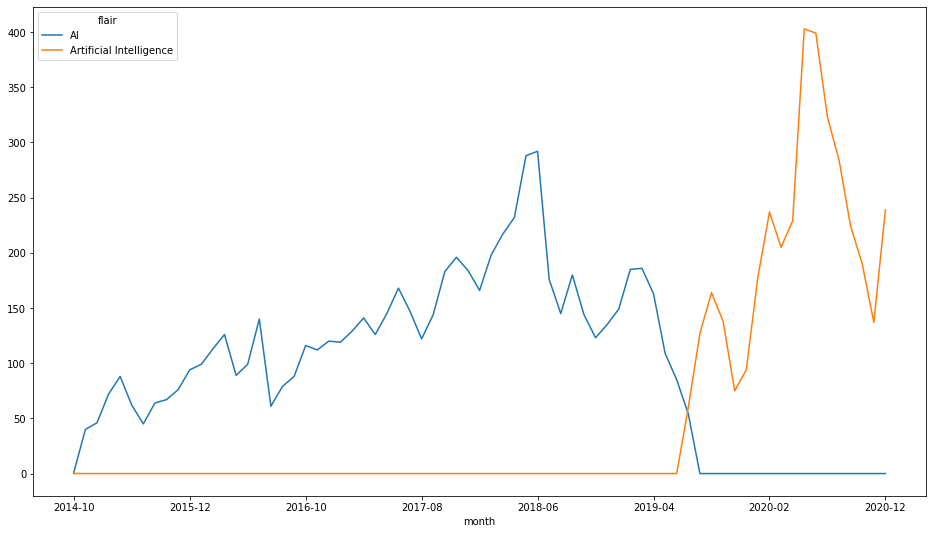

In [15]:
ai_fp = ai_flair.pivot(index="month", columns="flair", values="count").fillna(0)
ai_fp.plot(figsize=(16,9))

In [16]:
total_posts = pd.read_sql("SELECT STRFTIME('%Y-%m', created_utc) AS month, COUNT(*) AS count \
                          FROM posts2020 WHERE parent_id IS NULL \
                          GROUP BY month", sql)

In [17]:
ai_fpt = ai_fp.merge(total_posts, left_index=True, right_on="month").set_index("month")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


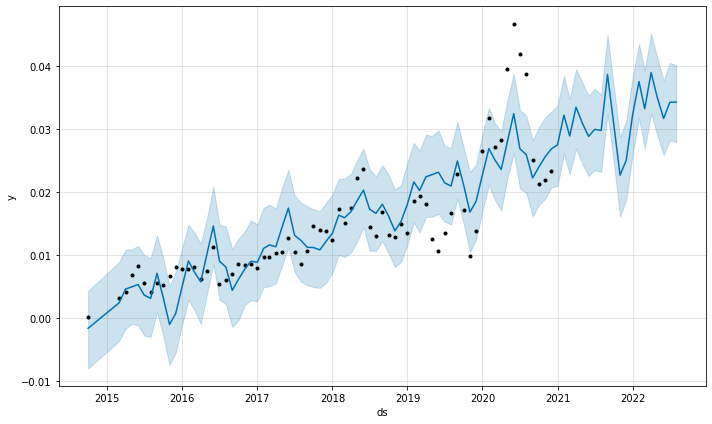

In [18]:
pa = pd.DataFrame()
pa["ds"] = ai_fpt.index
pa["y"] = ((ai_fpt["Artificial Intelligence"] + ai_fpt["AI"])/ai_fpt["count"]).values
m = Prophet()
m.fit(pa)
future = m.make_future_dataframe(periods=20, freq='M')
forecast = m.predict(future)
fig1 = m.plot(forecast)

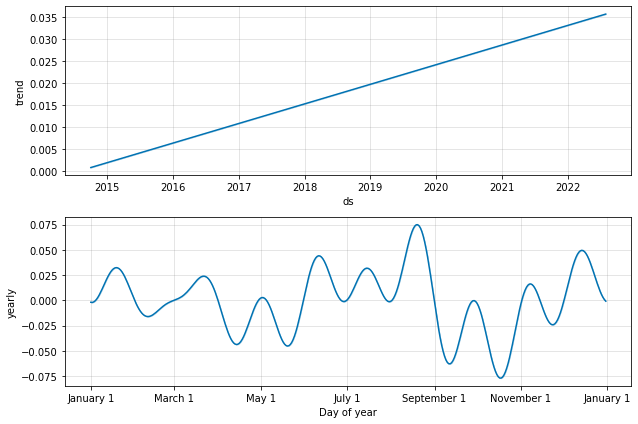

In [19]:
fig2 = m.plot_components(forecast)